In [60]:
from scripts.sequence_labeling import f1_score, precision_score, recall_score, get_entities
from scripts.scheme import IOB2
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle

### 1. Read the predictions and the gold labels of the test set

In [2]:
preds = pd.read_csv('./output/i2b2-2010/test_predictions.txt', delimiter=" ", header = None)
preds.columns = ["word", "label"]
golds = pd.read_csv('../datasets/NER/i2b2-2010/processed/merged/test.txt', delimiter=" ", header = None)
golds.columns = ["word", "label"]
preds.head(10)

,word,label
0,032890433,O
1,CTMC,O
2,75066875,O
3,828710,O
4,02/21/1991,O
5,12:00:00,O
6,AM,O
7,Discharge,O
8,Summary,O
9,Unsigned,O


#### 1.1 Make sure the words in preds and golds are correctly stored and of the same order
- you might need to replace all of the double quotes to single quotes in both test_predictions.txt and test.txt

In [3]:
df1 = preds[preds['word']!=golds['word']]
df2 = golds[preds['word']!=golds['word']]
dfs = pd.concat([df1,df2], axis=1)
dfs.columns = ["preds word", "preds label", "golds word", "golds label"]
print(len(dfs))
dfs

20


,preds word,preds label,golds word,golds label
8204,NaN,O,NaN,O
52252,NaN,O,NaN,O
52256,NaN,O,NaN,O
52260,NaN,O,NaN,O
52264,NaN,O,NaN,O
68028,NaN,O,NaN,O
74544,NaN,O,NaN,O
74548,NaN,O,NaN,O
150016,NaN,O,NaN,O
166888,NaN,O,NaN,O


- these "NaN" are the "n/a" in the text, they cannot be read properly by pandas but that makes no harm to our analysis since none of them belongs to the entities. Thus, we can just leave it
- And this cannot be solved by the "na_values" attribute in read_csv, since it's used to specify the additional NaN values but not modify the default ones

### 2. Check the frequency of each classes to see if they are balanced

#### 2.1 number of negatives (tag O) VS number of positives (tag B and I)

In [4]:
# get the BIO tags and classes in new columns
preds['BIO'] = preds['label'].str.split('-').str[0]
golds['BIO'] = golds['label'].str.split('-').str[0]
preds['class'] = preds['label'].str.split('-').str[1].fillna('O')
golds['class'] = golds['label'].str.split('-').str[1].fillna('O')
# preds.head(30)

In [5]:
# prepare the dataframe to see the tag balance in preds and golds
df_p = preds
df_p['type'] = 'pred'
df_g = golds
df_g['type'] = 'gold'
df_all = pd.concat([df_p,df_g], axis=0)
# df_all

<AxesSubplot:xlabel='BIO', ylabel='count'>

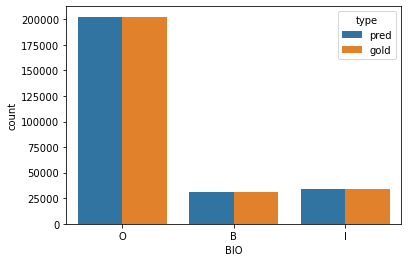

In [6]:
sns.countplot(x='BIO', hue='type', data=df_all)

In [7]:
print(f"In preds, the ratio of #Neg(O) and #Pos(B,I) is {preds['BIO'].value_counts()['O']/(preds['BIO'].value_counts()['B']+preds['BIO'].value_counts()['I'])}")
print(f"In golds, the ratio of #Neg(O) and #Pos(B,I) is {golds['BIO'].value_counts()['O']/(golds['BIO'].value_counts()['B']+golds['BIO'].value_counts()['I'])}")

In preds, the ratio of #Neg(O) and #Pos(B,I) is 3.1216262068540055
In golds, the ratio of #Neg(O) and #Pos(B,I) is 3.12397956821654


#### 2.2 #O VS #problem VS #test VS #treatment

In [8]:
df_all

,word,label,BIO,class,type
0,032890433,O,O,O,pred
1,CTMC,O,O,O,pred
2,75066875,O,O,O,pred
3,828710,O,O,O,pred
4,02/21/1991,O,O,O,pred
...,...,...,...,...,...
267233,(,O,O,O,gold
267234,End,O,O,O,gold
267235,of,O,O,O,gold
267236,Report,O,O,O,gold


<AxesSubplot:xlabel='class', ylabel='count'>

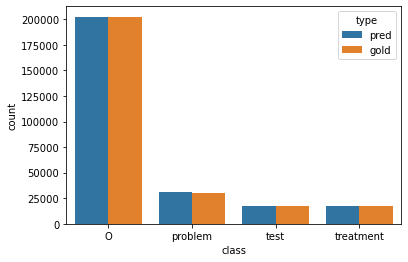

In [9]:
sns.countplot(x='class', hue='type', data=df_all)

In [10]:
n_preds = preds['class'].value_counts()['problem'] + preds['class'].value_counts()['test'] + preds['class'].value_counts()['treatment']
n_golds = golds['class'].value_counts()['problem'] + golds['class'].value_counts()['test'] + golds['class'].value_counts()['treatment']
print(f"Proportions of different entity class in preds: PROBLEM {(preds['class'].value_counts()['problem']/n_preds):.2%}, TEST {(preds['class'].value_counts()['test']/n_preds):.2%}, TREATMENT {(preds['class'].value_counts()['treatment']/n_preds):.2%}")
print(f"Proportions of different entity class in golds: PROBLEM {(golds['class'].value_counts()['problem']/n_golds):.2%}, TEST {(golds['class'].value_counts()['test']/n_golds):.2%}, TREATMENT {(golds['class'].value_counts()['treatment']/n_golds):.2%}")

Proportions of different entity class in preds: PROBLEM 47.49%, TEST 26.38%, TREATMENT 26.14%
Proportions of different entity class in golds: PROBLEM 46.71%, TEST 26.60%, TREATMENT 26.69%


- There is imbalance in the classes. The PROBLEM class takes the majority. We could seek the help from Dice Loss, which is a soft version of f1-score that can possibly help narrows down the gap between the f1-score in evalutaion and loss in training

#### 2.3 frequency of different classes in the false positives and false negatives

In [11]:
df_p[70:90]

,word,label,BIO,class,type
70,a,B-problem,B,problem,pred
71,complex,I-problem,I,problem,pred
72,left,I-problem,I,problem,pred
73,renal,I-problem,I,problem,pred
74,mass,I-problem,I,problem,pred
75,.,O,O,O,pred
76,A,B-test,B,test,pred
77,computerized,I-test,I,test,pred
78,tomography,I-test,I,test,pred
79,scan,I-test,I,test,pred


In [12]:
def capture_lines(df, column):
    """
    get sentences/entities in list of list
    """
    sep_list = list(df[df["word"] == "."].index)
    last_sep = 0
    list_sent = []
    for _, x in enumerate(sep_list):
        sentence = list(df[column][last_sep : x+1])
        list_sent.append(sentence)
        last_sep = x+1
    return list_sent

In [13]:
sents_p = capture_lines(df_p, "word")
sents_g = capture_lines(df_g, "word")
ents_p = capture_lines(df_p, "label")
ents_g = capture_lines(df_g, "label")
# example
print("example sentence: ", " ".join(sents_p[70]))
print("example entities: ",ents_p[70])

example sentence:  7. Neurology : Head ultrasound on day of life seven showed no intraventricular hemorrhage .
example entities:  ['O', 'O', 'O', 'B-test', 'I-test', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-problem', 'I-problem', 'O']


In [14]:
# def tp_fp_fn_lenient(y_true, y_pred, suffix, *args):
# lenient score
y_true = ents_g
y_pred = ents_p
suffix = None
entities_true = defaultdict(set)
entities_pred = defaultdict(set)
for type_name, start, end, _ in get_entities(y_true, suffix):
    entities_true[type_name].add((start, end))
for type_name, start, end, _ in get_entities(y_pred, suffix):
    entities_pred[type_name].add((start, end))
target_names = sorted(set(entities_true.keys()) | set(entities_pred.keys()))

tp_sum = np.array([], dtype=np.int32)
pred_sum = np.array([], dtype=np.int32)
true_sum = np.array([], dtype=np.int32)
for type_name in target_names:

    entities_true_type = sorted(entities_true.get(type_name, set()))
    entities_pred_type = sorted(entities_pred.get(type_name, set()))
    tp = 0
    for idt, xt in enumerate(entities_true_type):
        for idp, xp in enumerate(entities_pred_type):
            if (xp[0] < xt[1] and xp[1] > xt[0]) or (xp[0] == xp[1] == xt[0] == xt[1]):
                tp += 1
                break
    tp_sum = np.append(tp_sum, tp)
    pred_sum = np.append(pred_sum, len(entities_pred_type))
    true_sum = np.append(true_sum, len(entities_true_type))
    fp_sum = pred_sum - tp_sum
    fn_sum = true_sum - tp_sum

    # return pred_sum, tp_sum, true_sum

In [15]:
nw = np.append(fp_sum,fn_sum)

In [16]:
df_error = pd.DataFrame(columns=['class', 'count', 'type'])
# # df_error['type'] = "fp"
# df_error = pd.concat((df_error, pd.DataFrame(fn_sum.reshape(1,-1), columns=['problem', 'test', 'treatment'])), axis=0, ignore_index=True)
# # df_error.at[1,'type'] = "fn"
# df_error = df_error.rename(index={0:'fp',1:'fn'})
df_error['class'] = ['problem','test','treatment','problem','test','treatment']
df_error['count'] = nw
df_error['type'] = ['FP','FP','FP','FN','FN','FN']
df_error

,class,count,type
0,problem,1327,FP
1,test,1093,FP
2,treatment,1040,FP
3,problem,885,FN
4,test,998,FN
5,treatment,926,FN


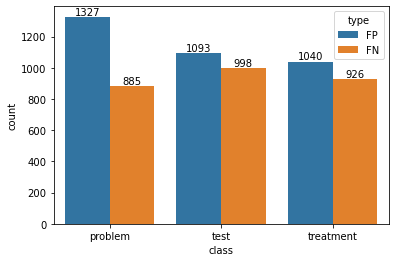

In [17]:
plots = sns.barplot(x='class', y='count',hue='type',data=df_error)
# Iterrating over the bars one-by-one to add annotations
for bar in plots.patches:
    plots.annotate(format(int(bar.get_height())),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

In [18]:
print(f"Proportions of different entity class in False Positives: PROBLEM {(fp_sum[0]/fp_sum.sum()):.2%}, TEST {(fp_sum[1]/fp_sum.sum()):.2%}, TREATMENT {(fp_sum[2]/fp_sum.sum()):.2%}")
print(f"Proportions of different entity class in False Negatives: PROBLEM {(fn_sum[0]/fn_sum.sum()):.2%}, TEST {(fn_sum[1]/fn_sum.sum()):.2%}, TREATMENT {(fn_sum[2]/fn_sum.sum()):.2%}")

Proportions of different entity class in False Positives: PROBLEM 38.35%, TEST 31.59%, TREATMENT 30.06%
Proportions of different entity class in False Negatives: PROBLEM 31.51%, TEST 35.53%, TREATMENT 32.97%


- The model tends to predict more "problem" entities while the "test" entities are harder to be detected

### 3. Locate the error sentences

In [56]:
# get the FN and FP dictionaries and save
y_true = ents_g
y_pred = ents_p
suffix = None
entities_true = defaultdict(set)
entities_pred = defaultdict(set)

for type_name, start, end, (sent_id, ent_id) in get_entities(y_true, suffix):
    entities_true[type_name].add((start, end, (sent_id, ent_id)))
for type_name, start, end, (sent_id, ent_id) in get_entities(y_pred, suffix):
    entities_pred[type_name].add((start, end, (sent_id, ent_id)))
target_names = sorted(set(entities_true.keys()) | set(entities_pred.keys()))

fn = dict()
fp = dict()
for type_name in target_names:

    entities_true_type = sorted(entities_true.get(type_name, set()))
    entities_pred_type = sorted(entities_pred.get(type_name, set()))
    fn[type_name] = []
    fp[type_name] = []

    for idt, xt in enumerate(entities_true_type):
        mark_match = -1
        for idp, xp in enumerate(entities_pred_type):
            if (xp[0] < xt[1] and xp[1] > xt[0]) or (xp[0] == xp[1] == xt[0] == xt[1]):
                mark_match = idp
                break
        if idp == len(entities_pred_type)-1 and mark_match == -1:
            fn[type_name].append(xt)
    
    for idp, xp in enumerate(entities_pred_type):
        mark_match = -1
        for idt, xt in enumerate(entities_true_type):
            if (xp[0] < xt[1] and xp[1] > xt[0]) or (xp[0] == xp[1] == xt[0] == xt[1]):
                mark_match = idt
                break
        if idt == len(entities_true_type)-1 and mark_match == -1:
            fp[type_name].append(xp)

In [107]:
with open('./analysis_2010/fp.json', 'wb') as f:
    pickle.dump(fp, f)
with open('./analysis_2010/fn.json', 'wb') as f:
    pickle.dump(fn, f)

In [102]:
error_id = 4
sent_id = fn['problem'][error_id][2][0]
print(tabulate([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]], tablefmt='orgtbl'))

| We | think | this | is | likely | due | to | an          | SIADH       | as | she | is | euvolemic | . |
| O  | O     | O    | O  | O      | O   | O  | B-problem   | I-problem   | O  | O   | O  | O         | O |
| O  | O     | O    | O  | O      | O   | O  | B-treatment | I-treatment | O  | O   | O  | B-problem | O |


In [77]:
check_fn = pd.DataFrame([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]])
check_fn = check_fn.rename(index={0:'sentence',1:'gold',2:'pred'})
check_fn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
sentence,We,think,this,is,likely,due,to,an,SIADH,as,she,is,euvolemic,.
gold,O,O,O,O,O,O,O,B-problem,I-problem,O,O,O,O,O
pred,O,O,O,O,O,O,O,B-treatment,I-treatment,O,O,O,B-problem,O


In [143]:
for error_id in range(len(fn['problem'])):
    sent_id = fn['problem'][error_id][2][0]
    ent_id = fn['problem'][error_id][2][1]
    with open("./analysis_2010/fn_analysis/fn_tabular_"+str(sent_id)+".txt", "a") as text_file:
        text_file.write(f"FN in entity {ent_id} \n")
        text_file.write(tabulate([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]], tablefmt='orgtbl')+'\n')

In [145]:
for error_id in range(len(fp['problem'])):
    sent_id = fp['problem'][error_id][2][0]
    ent_id = fp['problem'][error_id][2][1]
    with open("./analysis_2010/fp_analysis/fp_tabular_"+str(sent_id)+".txt", "a") as text_file:
        text_file.write(f"FP in entity {ent_id} \n")
        text_file.write(tabulate([sents_g[sent_id],ents_g[sent_id],ents_p[sent_id]], tablefmt='orgtbl')+'\n')